# Histophathologic Cancer Detection
## Alex Melnick - alme9138

### Problem

I will be attempting to construct and train a convolutional neural network in order to detect the presence of cancerous tumors in medical imagery. The dataset, accessed from [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview) consists of a training set of 220,025 images and a testing set of 57,458 images. An image is determined to correspond to a cancerous sample if it contains a single pixel of tumor.

Class 0 = Cancer absent
Class 1 = Cancer present

### Acknowledgements

I used Leopold Tchomgwi's submission ([Accessed Here](https://www.kaggle.com/code/leopoldtchomgwi/lt-cancer-detection-final/notebook)) as a guide for the initial parsing of the data and creation of generators, but did not use the CNN or results.

[This article](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) helped me put together my history graphs.

### Preliminary Work

The initial cells below are used to extract the data from kaggle and unpack into the Google Collab environment.



In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download histopathologic-cancer-detection

100% 6.29G/6.31G [01:33<00:00, 74.4MB/s]
100% 6.31G/6.31G [01:33<00:00, 72.5MB/s]


In [6]:
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from os import listdir


### Data Exploration

I transformed the training labels and testing labels into pandas dataframes, then added the .tif filetype to allow easy translation to the images contained in the dataset. No NaN were found in the dataset.

I performed a simple exploration by counting the number of cancerous and non-cancerous samples in the training set to determine the balance of the dataset. The training data contains roughly 60% class 0 samples and 40% class 1 samples, which should pose no balance issues.

I also took an inexpert look at samples of both classes side by side. To my untrained eye, I cannot tell the difference, so I will certainly be relying on the powers of the CNN.

In [8]:
labels = pd.read_csv("/content/train_labels.csv", dtype = str)
test_final = pd.read_csv("/content/sample_submission.csv", dtype = str)
train_files = listdir("/content/train")
test_files = listdir("/content/test")
print("Train size: ", len(train_files))
print("Test size: ", len(test_files))
labels.id = labels.id + '.tif'
test_final.id = test_final.id + '.tif'

Train size:  220025
Test size:  57458


In [9]:
#Check for invalid entries

print(labels['label'].isna().sum())
print(test_final['label'].isna().sum())

0
0


Percent of training sample that is class 0: 59.50


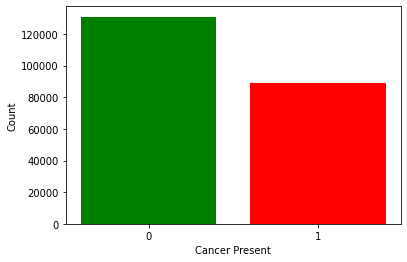

In [10]:
plt.bar(['0','1'], [len(labels[labels.label == '0']), len(labels[labels.label == '1'])], color=['green', 'red']);
plt.xlabel("Cancer Present");
plt.ylabel("Count");
print("Percent of training sample that is class 0: {:.2f}".format((len(labels[labels.label == '0'])/len(labels))*100))


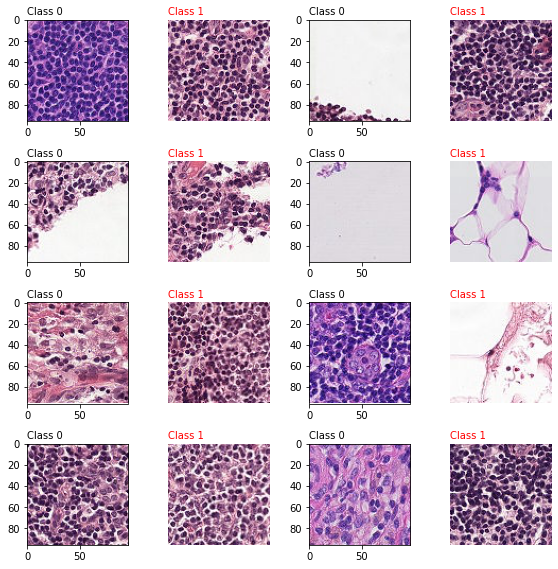

In [11]:
sample0 = labels[labels.label == '0'].sample(n=8).reset_index()
sample1 = labels[labels.label == '0'].sample(n=8).reset_index()

plt.figure(figsize=(8,8))

for i in range(0, 16,2):

  img0 = mpimg.imread('/content/train/' + sample0.id[i//2])
  img1 = mpimg.imread('/content/train/' + sample1.id[i//2])

  plt.subplot(4,4, i+1)
  plt.imshow(img0)
  plt.text(0,-5, 'Class 0', color='k')
  plt.subplot(4,4, i+2)
  plt.imshow(img1)
  plt.text(0,-5, 'Class 1', color='r')

  plt.axis('off')

plt.tight_layout()
plt.show()


### Approach and Results

I split the training set into a training set and a validation set (90/10). This will allow me to test for variance in the model. I used stratification to keep the balance of each set as similar as possible.

Both training and validation sets were converted into tensors with the keras IamgeDataGenerator method, then converted into generators for easy input into the CNN.

For model architecture, I initially began with 2 [Conv2d, Conv2d, maxpool] layers followed by a simple dense layer with 64 perceptrons. I read that the identification of cancer is based on a darker area (dyes are used to highlight the tumor), which made maxpool seem like a good method for ensuring those darker areas weren't lost. Since this is a binary classification problem, a sigmoid activiation function for the output layer was appropriate, though a softmax could also be used. To accompany the sigmoid function, I picked binary cross entropy, which shares the same advantages as categorical cross entropy, but is more appropriate for the sigmoid function.

I also used Adam and batch normalization to further enhance the model.

My initial training run was successful, but resulted in a testing accuracy of only 85%.

To enhance that result, I added a third convolutional layer pattern, using trial and error to settle on the number of filters (16, 32, 64) in each pattern. I instituted a learning rate that decreased over time to better pinpoint the gradient minimums. I also added a second dense layer to better differentiate the cancerous pixels.


In [12]:
train_set, test_set = train_test_split(labels, test_size=0.1, random_state=42, stratify=labels.label)

In [13]:
print("Percentage of cancerous results in training set: ", len(train_set[train_set.label == '1'])/len(train_set)*100)
print("Percentage of cancerous results in testing set: ", len(test_set[test_set.label == '1'])/len(test_set)*100)

Percentage of cancerous results in training set:  40.50307541586288
Percentage of cancerous results in testing set:  40.503567695314274


In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train_set, directory = '/content/train/', x_col = 'id', y_col = "label", seed = 42, class_mode = 'categorical', batch_size = 32, target_size = (96, 96))
test_generator = test_datagen.flow_from_dataframe(dataframe = test_set, directory = '/content/train/', x_col = 'id', y_col = "label", seed = 42, class_mode = 'categorical', batch_size = 32, target_size = (96, 96))

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3),activation ='relu', input_shape=(96, 96, 3)))
model.add(layers.Conv2D(16, (3,3), activation ='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation ='relu'))
model.add(layers.Conv2D(32, (3,3), activation ='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation ='relu'))
model.add(layers.Conv2D(64, (3,3), activation ='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 32)        9

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(opt, loss='binary_crossentropy',metrics=['accuracy'])

history1 = model.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=10, verbose =1, use_multiprocessing=True)

K.set_value(model.optimizer.learning_rate, 0.0001)

history2 = model.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=10, verbose =1, use_multiprocessing=True)

K.set_value(model.optimizer.learning_rate, 0.00001)

history3 = model.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=10, verbose =1, use_multiprocessing=True)

Epoch 1/10
6189/6189 [==============================] - 452s 71ms/step - loss: 0.3452 - accuracy: 0.8518 - val_loss: 0.3764 - val_accuracy: 0.8679
Epoch 2/10
6189/6189 [==============================] - 348s 56ms/step - loss: 0.2597 - accuracy: 0.8950 - val_loss: 0.2450 - val_accuracy: 0.9025
Epoch 3/10
6189/6189 [==============================] - 351s 57ms/step - loss: 0.2253 - accuracy: 0.9115 - val_loss: 0.2793 - val_accuracy: 0.8820
Epoch 4/10
6189/6189 [==============================] - 313s 51ms/step - loss: 0.2001 - accuracy: 0.9224 - val_loss: 0.4296 - val_accuracy: 0.8328
Epoch 5/10
6189/6189 [==============================] - 305s 49ms/step - loss: 0.1834 - accuracy: 0.9299 - val_loss: 0.2155 - val_accuracy: 0.9184
Epoch 6/10
6189/6189 [==============================] - 305s 49ms/step - loss: 0.1667 - accuracy: 0.9369 - val_loss: 0.2595 - val_accuracy: 0.8949
Epoch 7/10
6189/6189 [==============================] - 302s 49ms/step - loss: 0.1536 - accuracy: 0.9421 - val_loss: 0

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy: %.2f' % (accuracy))

688/688 [==============================] - 15s 22ms/step - loss: 0.3367 - accuracy: 0.9311
Test accuracy: 0.93


In [ ]:
combinedHistory = {}
for key in history1.history.keys():
  combinedHistory[key] = history1.history[key] + history2.history[key] + history3.history[key]



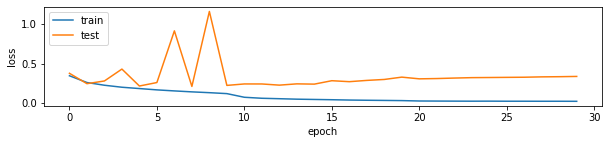

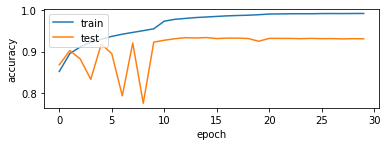

In [ ]:
plt.figure(figsize=[10,4])

plt.subplot(2, 1, 1)
plt.plot(combinedHistory['loss']);
plt.plot(combinedHistory['val_loss']);
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(combinedHistory['accuracy']);
plt.plot(combinedHistory['val_accuracy']);
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Intermediate Analysis

Based on the graphs of loss and accuracy, it appears that overfitting begins to occur after the first 10 epochs. In response to this, I will shorten the number of epochs to 8 for the initial learning rate, then 5 for each subsequent learning rate.

I also experimented with adding dense layers, but this exacerbated the overtraining issue.

In [16]:
model2 = models.Sequential()
model2.add(layers.Conv2D(16, (3,3),activation ='relu', input_shape=(96, 96, 3)))
model2.add(layers.Conv2D(16, (3,3), activation ='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(32, (3,3), activation ='relu'))
model2.add(layers.Conv2D(32, (3,3), activation ='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation ='relu'))
model2.add(layers.Conv2D(64, (3,3), activation ='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(2, activation='sigmoid'))


model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 32)        9

In [17]:
opt2 = tf.keras.optimizers.Adam(learning_rate = 0.001)

model2.compile(opt2, loss='binary_crossentropy',metrics=['accuracy'])

history1a = model2.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=8, verbose =1, use_multiprocessing=True)

K.set_value(model2.optimizer.learning_rate, 0.0001)

history2a = model2.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=5, verbose =1, use_multiprocessing=True)

K.set_value(model2.optimizer.learning_rate, 0.00001)

history3a = model2.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=5, verbose =1, use_multiprocessing=True)

#save model

model2.save("\content\drive\MyDrive\model2")

Epoch 1/8
6189/6189 [==============================] - 443s 69ms/step - loss: 0.3551 - accuracy: 0.8480 - val_loss: 0.3006 - val_accuracy: 0.8755
Epoch 2/8
6189/6189 [==============================] - 343s 55ms/step - loss: 0.2708 - accuracy: 0.8899 - val_loss: 0.6005 - val_accuracy: 0.7767
Epoch 3/8
6189/6189 [==============================] - 321s 52ms/step - loss: 0.2356 - accuracy: 0.9067 - val_loss: 0.2494 - val_accuracy: 0.8957
Epoch 4/8
6189/6189 [==============================] - 311s 50ms/step - loss: 0.2112 - accuracy: 0.9175 - val_loss: 0.3313 - val_accuracy: 0.8615
Epoch 5/8
6189/6189 [==============================] - 309s 50ms/step - loss: 0.1919 - accuracy: 0.9260 - val_loss: 0.2324 - val_accuracy: 0.9061
Epoch 6/8
6189/6189 [==============================] - 309s 50ms/step - loss: 0.1761 - accuracy: 0.9323 - val_loss: 0.2916 - val_accuracy: 0.8844
Epoch 7/8
6189/6189 [==============================] - 319s 51ms/step - loss: 0.1627 - accuracy: 0.9379 - val_loss: 0.2019 -

NameError: ignored

In [22]:
model2.save("\content\drive\MyDrive\model2")

INFO:tensorflow:Assets written to: \content\drive\MyDrive\model2/assets


In [18]:
combinedHistorya = {}
for key in history1a.history.keys():
  combinedHistorya[key] = history1a.history[key] + history2a.history[key] + history3a.history[key]

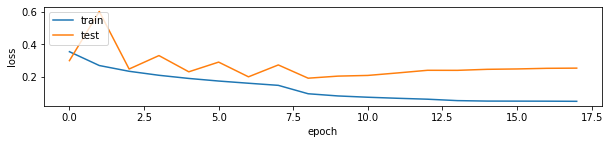

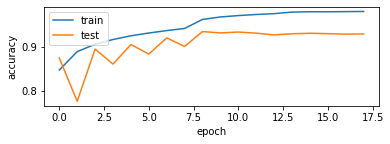

In [19]:
plt.figure(figsize=[10,4])

plt.subplot(2, 1, 1)
plt.plot(combinedHistorya['loss']);
plt.plot(combinedHistorya['val_loss']);
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(combinedHistorya['accuracy']);
plt.plot(combinedHistorya['val_accuracy']);
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Intermediate Analysis

This seemed to perform better, however after 8 epochs with the highest learning rate, little improvement in the validation set indicated further overtraining. To compensate, I simplified the model and further restricted the initial epochs to 6, followed by just 2 at a learning rate of .0001.

In [35]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3),activation ='relu', input_shape=(96, 96, 3)))
model3.add(layers.Conv2D(32, (3,3), activation ='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(64, (3,3), activation ='relu'))
model3.add(layers.Conv2D(64, (3,3), activation ='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(2, activation='sigmoid'))


model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 42, 42, 64)       

### Final Analysis

I would prefer to experiment further, however this seems like the sweet spot for the initial learning rate. We can see shifting to a lower learning rate further enhances the validation performance for a single epoch, then degrades. I used this for my submission, however, lacking the time for further experimentation.

I would do a single epoch at a reduced learning rate of .0001 and .00001 based on my findings here.

In Kaggle, I earned a grade of 0.83.

In [36]:
opt3 = tf.keras.optimizers.Adam(learning_rate = 0.001)

model3.compile(opt3, loss='binary_crossentropy',metrics=['accuracy'])

history1b = model3.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=6, verbose =1, use_multiprocessing=True)

K.set_value(model3.optimizer.learning_rate, 0.0001)

history1c = model3.fit(train_generator, steps_per_epoch = len(train_generator), validation_data=test_generator, validation_steps = len(test_generator), epochs=2, verbose =1, use_multiprocessing=True)

model3.save("\content\drive\MyDrive\model3")

Epoch 1/6
6189/6189 [==============================] - 353s 57ms/step - loss: 0.3522 - accuracy: 0.8529 - val_loss: 0.5652 - val_accuracy: 0.7854
Epoch 2/6
6189/6189 [==============================] - 315s 51ms/step - loss: 0.2579 - accuracy: 0.8969 - val_loss: 1.1339 - val_accuracy: 0.7324
Epoch 3/6
6189/6189 [==============================] - 308s 50ms/step - loss: 0.2173 - accuracy: 0.9142 - val_loss: 0.2662 - val_accuracy: 0.8992
Epoch 4/6
6189/6189 [==============================] - 319s 51ms/step - loss: 0.1892 - accuracy: 0.9261 - val_loss: 0.2564 - val_accuracy: 0.9062
Epoch 5/6
6189/6189 [==============================] - 308s 50ms/step - loss: 0.1644 - accuracy: 0.9364 - val_loss: 0.4471 - val_accuracy: 0.8175
Epoch 6/6
6189/6189 [==============================] - 308s 50ms/step - loss: 0.1417 - accuracy: 0.9453 - val_loss: 0.3125 - val_accuracy: 0.8967
Epoch 1/2
6189/6189 [==============================] - 315s 51ms/step - loss: 0.0865 - accuracy: 0.9674 - val_loss: 0.2407 -

In [37]:
combinedHistoryb = {}
for key in history1b.history.keys():
  combinedHistoryb[key] = history1b.history[key] + history1c.history[key]

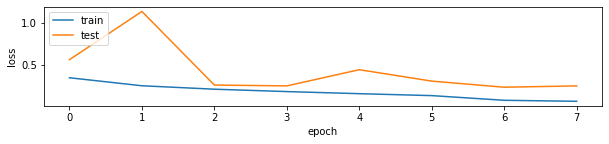

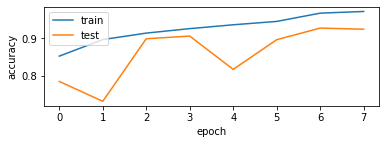

In [39]:
plt.figure(figsize=[10,4])

plt.subplot(2, 1, 1)
plt.plot(combinedHistoryb['loss']);
plt.plot(combinedHistoryb['val_loss']);
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(combinedHistoryb['accuracy']);
plt.plot(combinedHistoryb['val_accuracy']);
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:

test_final_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_final_generator = test_final_datagen.flow_from_dataframe(dataframe = test_final, directory = '/content/test/', x_col = 'id', y_col = "label", seed = 42, class_mode = 'categorical', batch_size = 32, target_size = (96, 96), shuffle=False)

Found 57458 validated image filenames belonging to 1 classes.


In [41]:
preds = model3.predict(test_final_generator, verbose = 1)



1796/1796 [==============================] - 75s 41ms/step


In [42]:
predictions = []

for pred in preds:

  if pred[0] > pred[1]:
    predictions.append(0)
  else:
    predictions.append(1)

In [43]:
submission = test_final.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head(30)



,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,1
6,aa0307865281d4484ddf8c637c348292968b93a7,0
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0


In [44]:
submission.to_csv('submission.csv',index=False)

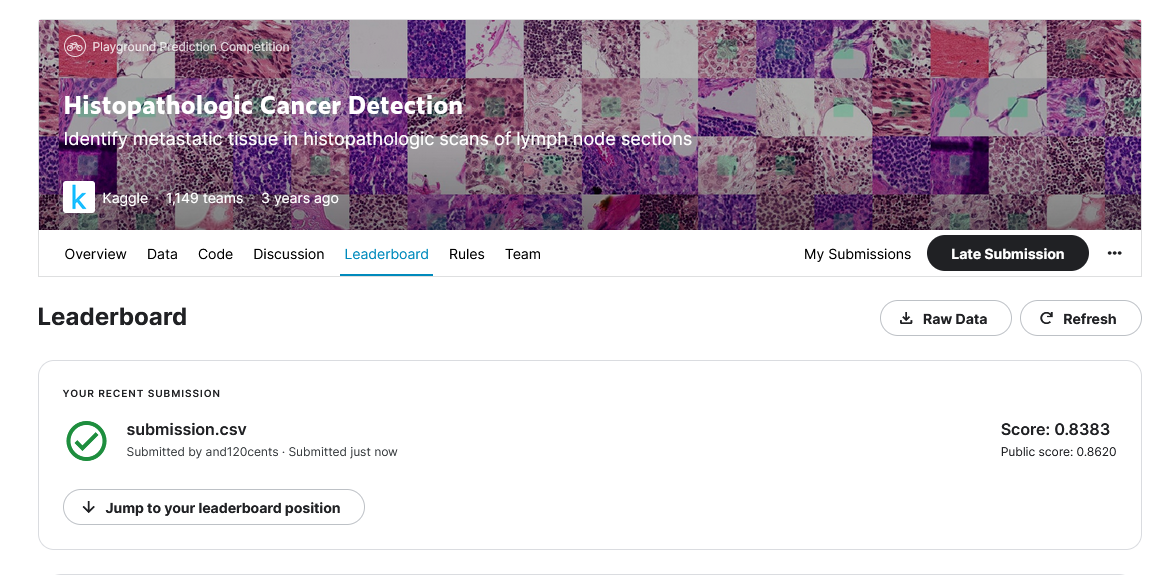